_This notebook was developed by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/ClassiPyGRB)._

# t-Distributed Stochastic Neighbor Embedding (t-SNE) Introduction in Swift/BAT data

The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/).

In previous notebooks, we pre-process Swift Data to apply T-SNE and other dimensionality reduction techniques. In this notebook, we use the [openTSNE](https://opentsne.readthedocs.io/en/latest/index.html) library to illustrate how we can customize t-SNE at a high level. Through this document, we are using the _python3_ implementations from the _ClassiPyGRB_ package. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we have to import the _SWIFT_ instance of _ClassiPyGRB_ to our notebook as well as other packages:

In [1]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np
from openTSNE import affinity
from openTSNE import TSNEEmbedding
from openTSNE import initialization

At this point, we need to load the data from the _SWIFT_ instance of _ClassiPyGRB_:

In [2]:
swift = SWIFT(root_path=r'type-your-path-here', res=64, n_bands=[1, 2, 3, 4, 5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


Now, from the [Preprocessing notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/20d417a5fa93f2a48ec1e5cb913484e87b05c339/docs/3.BAT_Preprocess.ipynb), obtain the GRB Names, pre-processed data, and the GRB durations $T_{90}$:

In [3]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|██████████| 1451/1451 [00:00<00:00, 2372.33GRB/s]


If you have not pre-process data yet, please check the [Preprocessing notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/20d417a5fa93f2a48ec1e5cb913484e87b05c339/docs/3.BAT_Preprocess.ipynb).

# t-SNE procedure

In the t-SNE algorithm, a standard optimization consists of five steps:

## Compute the affinities between data points:

In [4]:
affinities_train = affinity.PerplexityBasedNN(features, perplexity=30, metric="euclidean", n_jobs=os.cpu_count(), random_state=42, verbose=True)

===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 19.31 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds


## Generate initial coordinates for our embedding

We can use _random_ and _PCA_ (Principal Component Analysis) to initialize an embedding. Additionally, we can use _median_ and _weighted_mean_ in an existing embedding. Actually, it is recommended to initialize it using PCA:


In [5]:
init_train = initialization.pca(features, random_state=42, verbose=True)

===> Calculating PCA-based initialization...
   --> Time elapsed: 3.57 seconds


## Construct the ``TSNEEmbedding`` object

In [6]:
embedding_train = TSNEEmbedding(init_train, affinities_train, negative_gradient_method="fft", n_jobs=os.cpu_count(), verbose=True, learning_rate=310)

## Optimize Embedding

* Early exaggeration phase

In this phase, the attractive and repulsive forces between points are increased in a constant factor. By doing this, the convergence time is highly reduced without losing the general structure of the resulting embeddings.

===> Running optimization with exaggeration=12.00, lr=310.00 for 250 iterations...
Iteration   50, KL divergence 2.8391, 50 iterations in 0.7758 sec
Iteration  100, KL divergence 2.7655, 50 iterations in 0.7583 sec
Iteration  150, KL divergence 2.7336, 50 iterations in 0.7297 sec
Iteration  200, KL divergence 2.7326, 50 iterations in 4.8955 sec
Iteration  250, KL divergence 2.7326, 50 iterations in 1.2686 sec
   --> Time elapsed: 8.43 seconds


<Axes: >

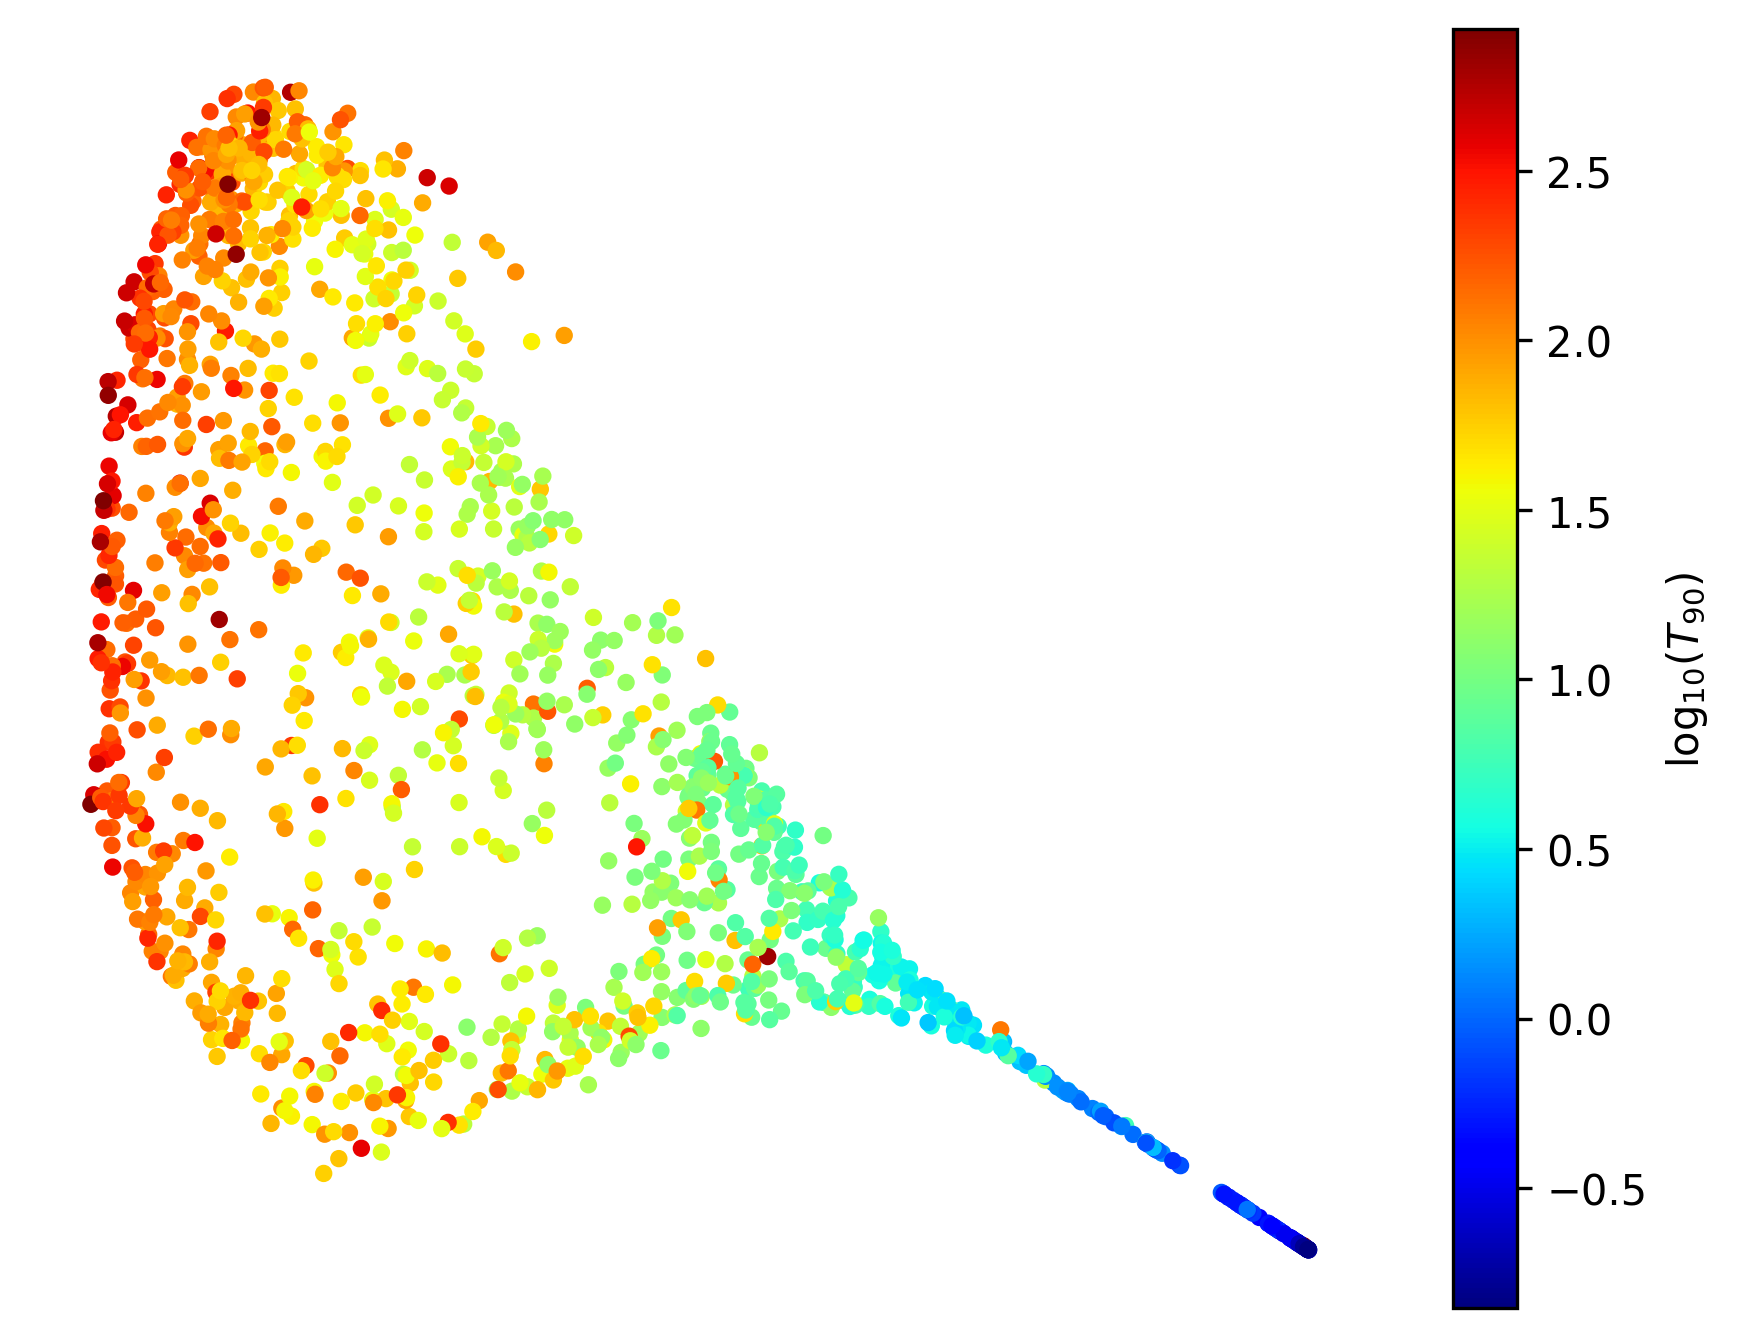

In [7]:
embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)
swift.plot_tsne(embedding_train_1, durations=durations)

* Regular optimization

In this phase, we disable the early exaggeration and let the algorithm modify position until some equilibrium point.

===> Running optimization with exaggeration=1.00, lr=310.00 for 250 iterations...
Iteration   50, KL divergence 1.1244, 50 iterations in 0.8470 sec
Iteration  100, KL divergence 1.0626, 50 iterations in 0.7895 sec
Iteration  150, KL divergence 1.0516, 50 iterations in 1.0376 sec
Iteration  200, KL divergence 1.0466, 50 iterations in 1.2262 sec
Iteration  250, KL divergence 1.0427, 50 iterations in 1.3187 sec
   --> Time elapsed: 5.22 seconds


<Axes: >

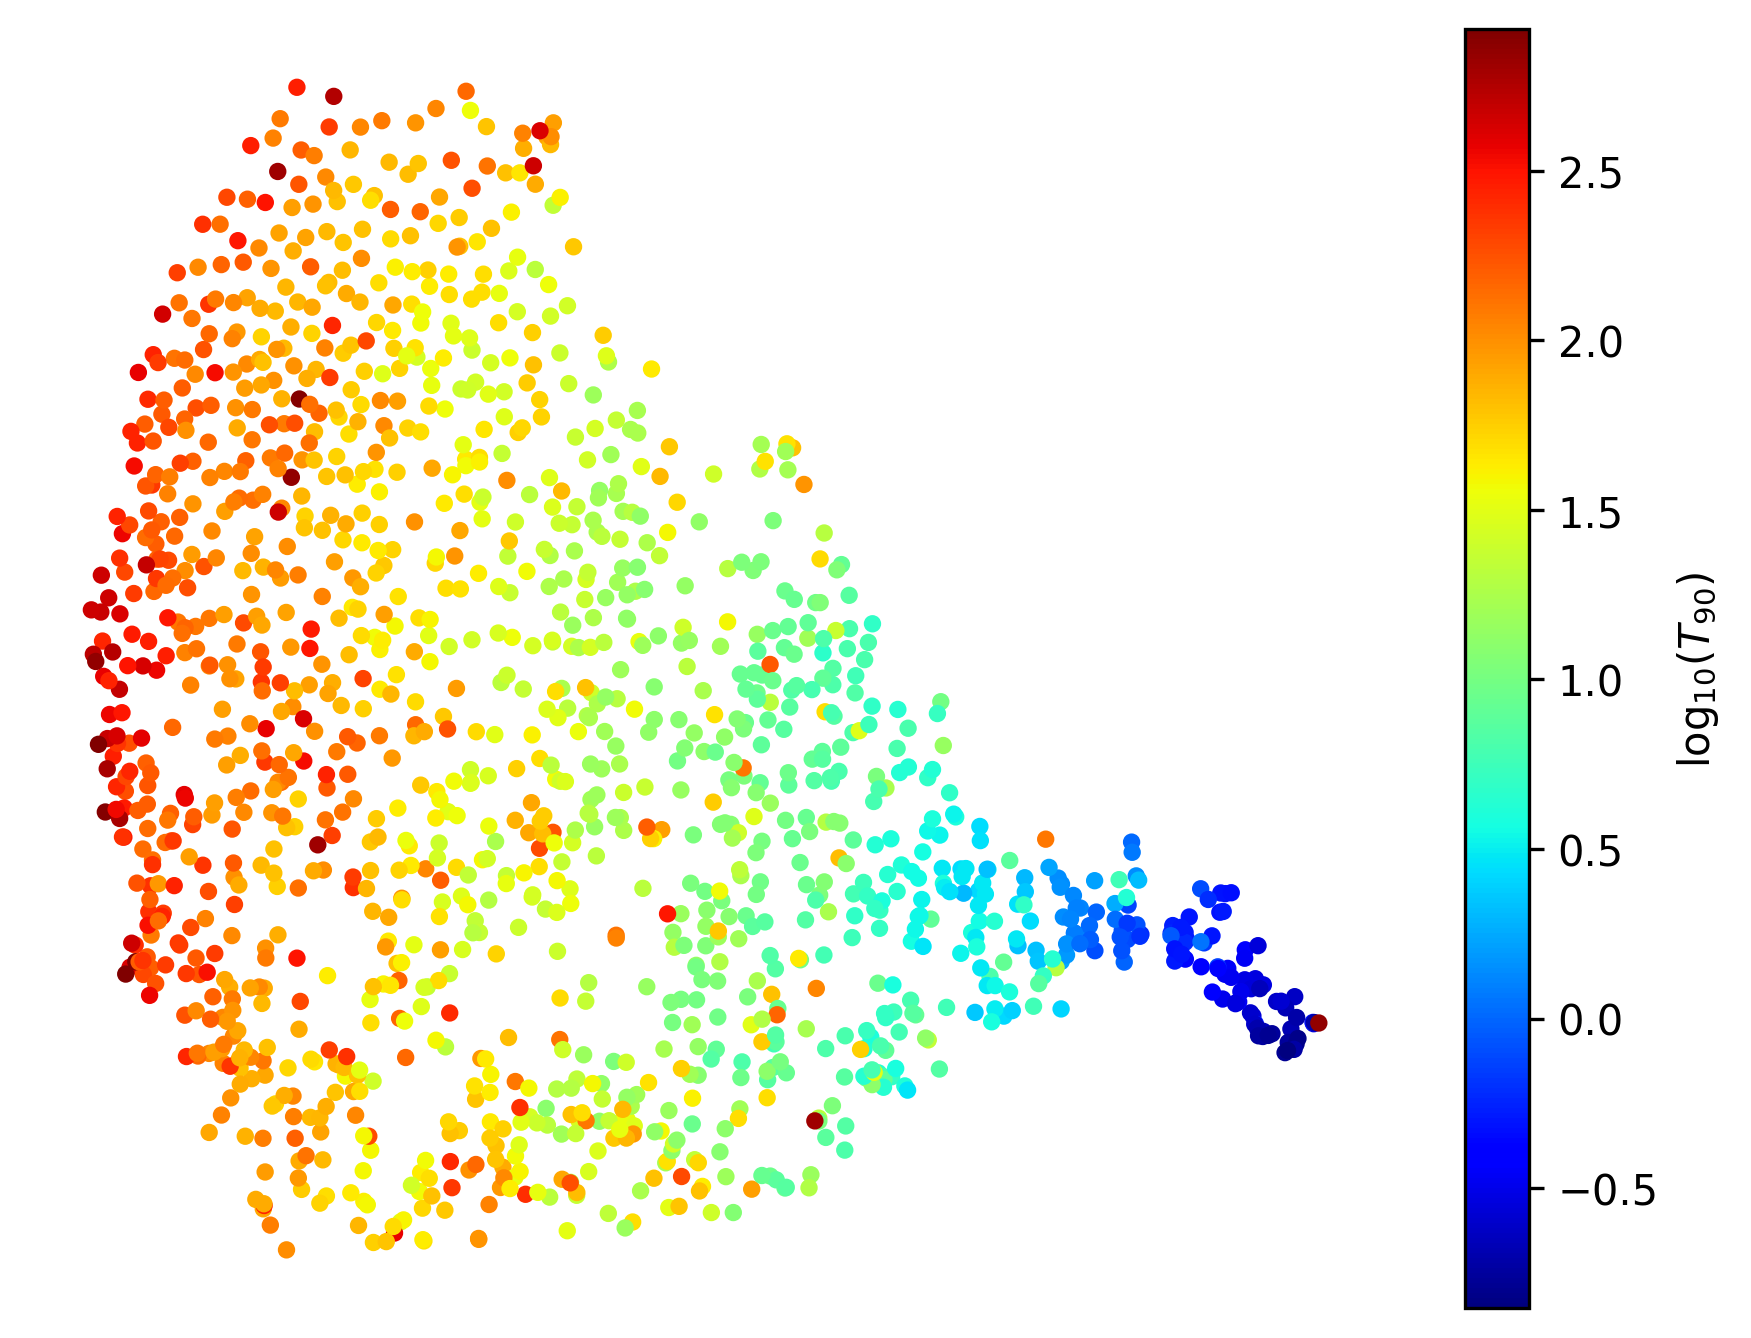

In [8]:
embedding_train_2 = embedding_train_1.optimize(n_iter=250, momentum=0.9)
swift.plot_tsne(embedding_train_2, durations=durations)

The visualization map results depend critically on the early exaggeration phase results. Optimizing the early phase is crucial to getting reliable embeddings. We remark that the embedding results do not change between libraries and therefore, there is a clear dependence between durations and the GRB light curves.

## Scikit results
By contrast, the same embedding using scikit Learn follows:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1451 samples in 0.025s...
[t-SNE] Computed neighbors for 1451 samples in 3.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1451
[t-SNE] Computed conditional probabilities for sample 1451 / 1451
[t-SNE] Mean sigma: 0.000391
[t-SNE] Computed conditional probabilities in 0.069s
[t-SNE] Iteration 50: error = 64.7156677, gradient norm = 0.0115540 (50 iterations in 0.303s)
[t-SNE] Iteration 100: error = 63.5632896, gradient norm = 0.0043459 (50 iterations in 0.302s)
[t-SNE] Iteration 150: error = 63.3329659, gradient norm = 0.0001025 (50 iterations in 0.323s)
[t-SNE] Iteration 200: error = 63.3296890, gradient norm = 0.0001216 (50 iterations in 0.333s)
[t-SNE] Iteration 250: error = 63.3301239, gradient norm = 0.0001038 (50 iterations in 0.310s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.330124
[t-SNE] Iteration 300: error = 1.2294184, gradient norm = 0.0105652 (50 iterations in 0.253s)

<Axes: >

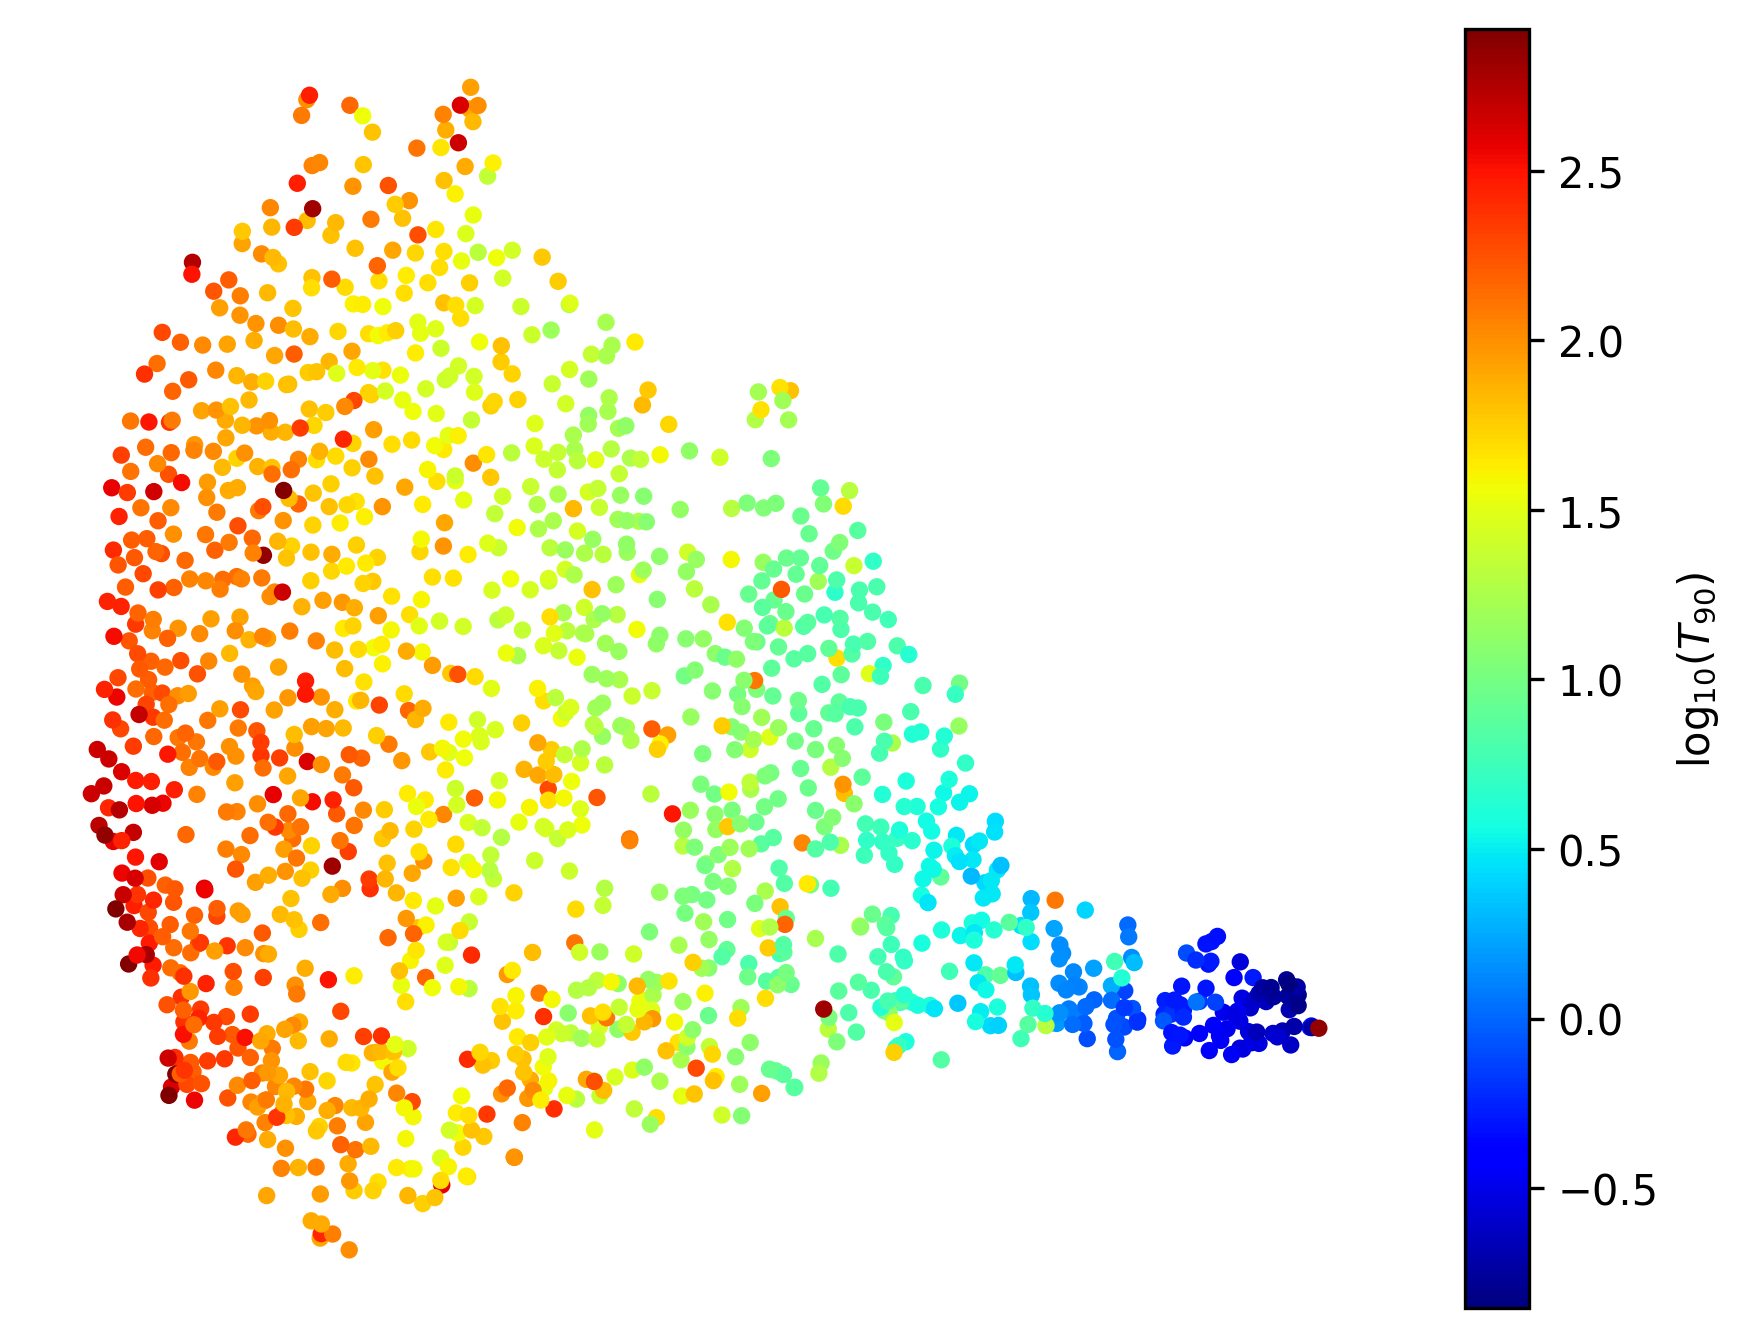

In [9]:
scikit_embedding = swift.perform_tsne(features, library='sklearn', perplexity=30, verbose=10, early_exaggeration=12, learning_rate=310/4, init='pca')
swift.plot_tsne(scikit_embedding, durations=durations)

As you can see from sklearn results, the embeddings follows the same structure of two subgroups and a strong correlation between $T_{90}$ and position. These results are the most interesting in the Swift/BAT dataset. In the next notebooks we will se that these groups corresponds to "short" and "long" GRBs from previous classifications.